In [1]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline
# charger des images formes (5547, 50, 50, 3)
X = np.load('D:/test cancer rbreast/crop/zoom_400m.npy')  

# charger des images  (5547,1); (0 = no cancer, 1 = cancer)
Y = np.load('D:/test cancer rbreast/crop/zoom_400m_label.npy')   
perm_array = np.arange(len(X))
#arrange genere tous toute les val jusqua la longuer de x_images
np.random.shuffle(perm_array)
#il melange les images
X = X[perm_array]
Y = Y[perm_array]
#en split notre dataset 80 % 20 %
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# en redduit la taille de l'echantillon au cas ou en avais trop d'images 
#pour pas que ca prend trop de temps pour le pc 
#mais ici c'est pas le cas donc en commente ce code
#X_train = X_train[0:30000] 
#Y_train = Y_train[0:30000]
#X_test = X_test[0:30000] 
#Y_test = Y_test[0:30000]
# normalizer nos donnees 
#en pourrais utiliser d'autre methodes aussi mais celle la c'est bien 
X_train = X_train / 256.0
X_test = X_test / 256.0
#methode qu'on a trouver sur internet et qu'on a utiliser 
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
#en applatit les donnees en gros en les transfrome en une matrice 1 seul dimmenssion nbr elem*(width*height*channel)
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    en va plot un learning curve grace au code de ce lien http://scikit-learn.org/stable/modules/learning_curve.html
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("exemples de test")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="score d'entrainement")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="score du cross validation")
    plt.legend(loc="best")
    return plt

def plotLotsOfLearningCurves(a,b):
    """ en va plot bcp de learning curve http://scikit-learn.org/stable/modules/learning_curve.html"""
    models = []
    models.append(('Support Vector Machine', SVC()))
    for name, model in models:
        plot_learning_curve(model, 'Learning Curve For %s Classifier'% (name), a,b, (0.5,1), 10)
#plotLotsOfLearningCurves(X_trainFlat, Y_train)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='matrice d econfusion',
                          cmap=plt.cm.Blues):
    """
    en affiche la matrice de confusion
    en peut normalizer les donnees en metant normalize a true
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Run SVC w/ Confusion Matrix
def runSVCconfusion(a,b,c,d):
    """methodes qui affiches les matrices de confusiondu model svc (comme exmeple) en normalizer et non normalizer"""
    model = SVC()
    model.fit(a, b)
    prediction = model.predict(c)
    kfold = model_selection.KFold(n_splits=10)
    accuracy = model_selection.cross_val_score(model, c,d, cv=kfold, scoring='accuracy')
    mean = accuracy.mean() 
    stdev = accuracy.std()
    print('\nSupport Vector Machine - Training set accuracy: %s (%s)' % (mean, stdev),"\n")
    cnf_matrix = confusion_matrix(d, prediction)
    np.set_printoptions(precision=2)
    class_names = ["diagnostic" "IDC(-)", "diagnostic" "IDC(+)"]
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, sans la normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title=' confusion matrix avec normalization')
    plt.show()
#runSVCconfusion(X_trainFlat, Y_train, X_testFlat, Y_test)
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

Using TensorFlow backend.


Train on 940 samples, validate on 236 samples
Epoch 1/100
940/940 [==============================] - 3s 3ms/step - loss: 0.5180 - acc: 0.8755 - val_loss: 0.4308 - val_acc: 0.7881

Epoch 00001: val_acc improved from -inf to 0.78814, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop_0layer.hdf5
Epoch 2/100
940/940 [==============================] - 1s 903us/step - loss: 0.2266 - acc: 0.9106 - val_loss: 0.6124 - val_acc: 0.6356

Epoch 00002: val_acc did not improve from 0.78814
Epoch 3/100
940/940 [==============================] - 1s 812us/step - loss: 0.1579 - acc: 0.9202 - val_loss: 1.2676 - val_acc: 0.7119

Epoch 00003: val_acc did not improve from 0.78814
Epoch 4/100
940/940 [==============================] - 1s 887us/step - loss: 0.1762 - acc: 0.9277 - val_loss: 1.2121 - val_acc: 0.7881

Epoch 00004: val_acc improved from 0.78814 to 0.78814, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop_0layer.hdf5
Epoch 5/100
940/940 [============================

940/940 [==============================] - 1s 811us/step - loss: 0.0416 - acc: 0.9872 - val_loss: 0.4768 - val_acc: 0.8941

Epoch 00041: val_acc did not improve from 0.94068
Epoch 42/100
940/940 [==============================] - 1s 804us/step - loss: 0.0363 - acc: 0.9894 - val_loss: 0.3318 - val_acc: 0.9110

Epoch 00042: val_acc did not improve from 0.94068
Epoch 43/100
940/940 [==============================] - 1s 801us/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.4475 - val_acc: 0.8814

Epoch 00043: val_acc did not improve from 0.94068
Epoch 44/100
940/940 [==============================] - 1s 805us/step - loss: 0.0124 - acc: 0.9957 - val_loss: 2.6817 - val_acc: 0.6653

Epoch 00044: val_acc did not improve from 0.94068
Epoch 45/100
940/940 [==============================] - 1s 796us/step - loss: 0.0074 - acc: 0.9979 - val_loss: 0.8652 - val_acc: 0.8178

Epoch 00045: val_acc did not improve from 0.94068
Epoch 46/100
940/940 [==============================] - 1s 800us/step - loss: 

940/940 [==============================] - 1s 825us/step - loss: 0.0056 - acc: 0.9979 - val_loss: 1.7661 - val_acc: 0.8008

Epoch 00085: val_acc did not improve from 0.94068
Epoch 86/100
940/940 [==============================] - 1s 859us/step - loss: 0.0031 - acc: 0.9989 - val_loss: 4.8302 - val_acc: 0.6102

Epoch 00086: val_acc did not improve from 0.94068
Epoch 87/100
940/940 [==============================] - 1s 844us/step - loss: 0.0091 - acc: 0.9979 - val_loss: 4.0393 - val_acc: 0.6695

Epoch 00087: val_acc did not improve from 0.94068
Epoch 88/100
940/940 [==============================] - 1s 800us/step - loss: 0.0033 - acc: 0.9979 - val_loss: 3.7996 - val_acc: 0.6780

Epoch 00088: val_acc did not improve from 0.94068
Epoch 89/100
940/940 [==============================] - 1s 802us/step - loss: 0.0031 - acc: 0.9989 - val_loss: 4.2906 - val_acc: 0.6610

Epoch 00089: val_acc did not improve from 0.94068
Epoch 90/100
940/940 [==============================] - 1s 806us/step - loss: 

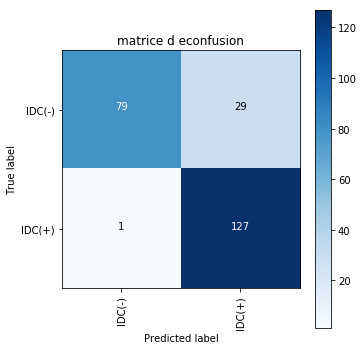

In [4]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_40zoom_modelcomplex_avec_crop.hdf5")
    for layer in model.layers[:0]:
        layer.trainable = False
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="weights.traint_40_400_zoom_modelcomplex_avec_crop_0layer.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 940 samples, validate on 236 samples
Epoch 1/100
940/940 [==============================] - 2s 2ms/step - loss: 0.6686 - acc: 0.8468 - val_loss: 0.3763 - val_acc: 0.8432

Epoch 00001: val_acc improved from -inf to 0.84322, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop3.hdf5
Epoch 2/100
940/940 [==============================] - 1s 627us/step - loss: 0.2054 - acc: 0.9138 - val_loss: 0.2384 - val_acc: 0.8729

Epoch 00002: val_acc improved from 0.84322 to 0.87288, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop3.hdf5
Epoch 3/100
940/940 [==============================] - 1s 622us/step - loss: 0.1980 - acc: 0.9149 - val_loss: 0.2039 - val_acc: 0.8983

Epoch 00003: val_acc improved from 0.87288 to 0.89831, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop3.hdf5
Epoch 4/100
940/940 [==============================] - 1s 614us/step - loss: 0.1147 - acc: 0.9457 - val_loss: 0.2302 - val_acc: 0.8856

Epoch 00004: val_acc did not impro

940/940 [==============================] - 1s 625us/step - loss: 0.0492 - acc: 0.9904 - val_loss: 0.5739 - val_acc: 0.9195

Epoch 00042: val_acc did not improve from 0.94915
Epoch 43/100
940/940 [==============================] - 1s 612us/step - loss: 0.0101 - acc: 0.9957 - val_loss: 0.5198 - val_acc: 0.9280

Epoch 00043: val_acc did not improve from 0.94915
Epoch 44/100
940/940 [==============================] - 1s 623us/step - loss: 0.0075 - acc: 0.9979 - val_loss: 0.3833 - val_acc: 0.9195

Epoch 00044: val_acc did not improve from 0.94915
Epoch 45/100
940/940 [==============================] - 1s 631us/step - loss: 0.0081 - acc: 0.9957 - val_loss: 0.3746 - val_acc: 0.9195

Epoch 00045: val_acc did not improve from 0.94915
Epoch 46/100
940/940 [==============================] - 1s 624us/step - loss: 0.0131 - acc: 0.9947 - val_loss: 0.5263 - val_acc: 0.9110

Epoch 00046: val_acc did not improve from 0.94915
Epoch 47/100
940/940 [==============================] - 1s 640us/step - loss: 

940/940 [==============================] - 1s 658us/step - loss: 0.0133 - acc: 0.9936 - val_loss: 0.4375 - val_acc: 0.9364

Epoch 00085: val_acc did not improve from 0.95339
Epoch 86/100
940/940 [==============================] - 1s 672us/step - loss: 0.0094 - acc: 0.9979 - val_loss: 0.5314 - val_acc: 0.9322

Epoch 00086: val_acc did not improve from 0.95339
Epoch 87/100
940/940 [==============================] - 1s 596us/step - loss: 0.0057 - acc: 0.9979 - val_loss: 0.5093 - val_acc: 0.9195

Epoch 00087: val_acc did not improve from 0.95339
Epoch 88/100
940/940 [==============================] - 1s 611us/step - loss: 0.0041 - acc: 0.9979 - val_loss: 0.4053 - val_acc: 0.9322

Epoch 00088: val_acc did not improve from 0.95339
Epoch 89/100
940/940 [==============================] - 1s 608us/step - loss: 0.0012 - acc: 0.9989 - val_loss: 0.4486 - val_acc: 0.9407

Epoch 00089: val_acc did not improve from 0.95339
Epoch 90/100
940/940 [==============================] - 1s 605us/step - loss: 

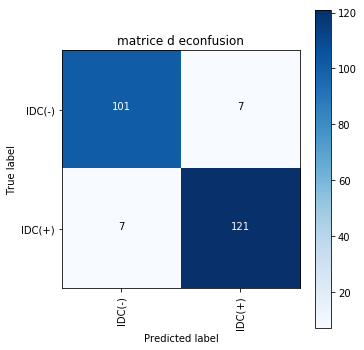

In [3]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_40zoom_modelcomplex_avec_crop.hdf5")
    for layer in model.layers[:5]:
        layer.trainable = False
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="weights.traint_40_400_zoom_modelcomplex_avec_crop3.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 940 samples, validate on 236 samples
Epoch 1/100
940/940 [==============================] - 2s 3ms/step - loss: 0.6765 - acc: 0.8638 - val_loss: 0.3951 - val_acc: 0.8559

Epoch 00001: val_acc improved from -inf to 0.85593, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop_10layer.hdf5
Epoch 2/100
940/940 [==============================] - 0s 499us/step - loss: 0.2183 - acc: 0.9202 - val_loss: 0.3229 - val_acc: 0.8559

Epoch 00002: val_acc did not improve from 0.85593
Epoch 3/100
940/940 [==============================] - 0s 492us/step - loss: 0.1608 - acc: 0.9309 - val_loss: 0.1801 - val_acc: 0.9195

Epoch 00003: val_acc improved from 0.85593 to 0.91949, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop_10layer.hdf5
Epoch 4/100
940/940 [==============================] - 0s 499us/step - loss: 0.1438 - acc: 0.9351 - val_loss: 0.1937 - val_acc: 0.9280

Epoch 00004: val_acc improved from 0.91949 to 0.92797, saving model to weights.traint_40_400_zoom

940/940 [==============================] - 0s 485us/step - loss: 0.1374 - acc: 0.9819 - val_loss: 0.5381 - val_acc: 0.9110

Epoch 00042: val_acc did not improve from 0.94492
Epoch 43/100
940/940 [==============================] - 0s 481us/step - loss: 0.0075 - acc: 0.9968 - val_loss: 0.5228 - val_acc: 0.9195

Epoch 00043: val_acc did not improve from 0.94492
Epoch 44/100
940/940 [==============================] - 0s 477us/step - loss: 0.0049 - acc: 0.9989 - val_loss: 0.4109 - val_acc: 0.9195

Epoch 00044: val_acc did not improve from 0.94492
Epoch 45/100
940/940 [==============================] - 0s 482us/step - loss: 0.0094 - acc: 0.9968 - val_loss: 0.4162 - val_acc: 0.9237

Epoch 00045: val_acc did not improve from 0.94492
Epoch 46/100
940/940 [==============================] - 0s 499us/step - loss: 0.0130 - acc: 0.9947 - val_loss: 0.3905 - val_acc: 0.9195

Epoch 00046: val_acc did not improve from 0.94492
Epoch 47/100
940/940 [==============================] - 0s 487us/step - loss: 

940/940 [==============================] - 0s 484us/step - loss: 0.0032 - acc: 0.9989 - val_loss: 0.5782 - val_acc: 0.9153

Epoch 00086: val_acc did not improve from 0.94492
Epoch 87/100
940/940 [==============================] - 0s 499us/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.4869 - val_acc: 0.9322

Epoch 00087: val_acc did not improve from 0.94492
Epoch 88/100
940/940 [==============================] - 0s 473us/step - loss: 0.0036 - acc: 0.9989 - val_loss: 0.4526 - val_acc: 0.9322

Epoch 00088: val_acc did not improve from 0.94492
Epoch 89/100
940/940 [==============================] - 0s 484us/step - loss: 0.0120 - acc: 0.9968 - val_loss: 0.6379 - val_acc: 0.9068

Epoch 00089: val_acc did not improve from 0.94492
Epoch 90/100
940/940 [==============================] - 0s 483us/step - loss: 0.0097 - acc: 0.9968 - val_loss: 0.3851 - val_acc: 0.9449

Epoch 00090: val_acc improved from 0.94492 to 0.94492, saving model to weights.traint_40_400_zoom_modelcomplex_avec_crop_10layer

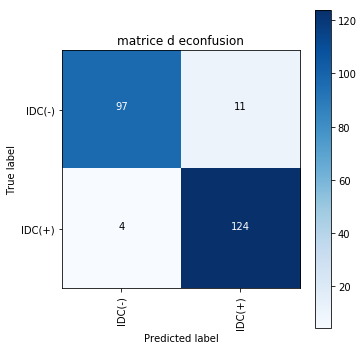

In [5]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_40zoom_modelcomplex_avec_crop.hdf5")
    for layer in model.layers[:10]:
        layer.trainable = False
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="weights.traint_40_400_zoom_modelcomplex_avec_crop_10layer.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()

Train on 940 samples, validate on 236 samples
Epoch 1/100
940/940 [==============================] - 2s 2ms/step - loss: 0.6211 - acc: 0.8574 - val_loss: 0.3155 - val_acc: 0.8941

Epoch 00001: val_acc improved from -inf to 0.89407, saving model to weights.traint_40_400_zoom_modelcomplex_avec_15layer.hdf5
Epoch 2/100
940/940 [==============================] - 0s 460us/step - loss: 0.3080 - acc: 0.8840 - val_loss: 0.2599 - val_acc: 0.8771

Epoch 00002: val_acc did not improve from 0.89407
Epoch 3/100
940/940 [==============================] - 0s 465us/step - loss: 0.2358 - acc: 0.9064 - val_loss: 0.3464 - val_acc: 0.8602

Epoch 00003: val_acc did not improve from 0.89407
Epoch 4/100
940/940 [==============================] - 0s 444us/step - loss: 0.1891 - acc: 0.9255 - val_loss: 0.2759 - val_acc: 0.8729

Epoch 00004: val_acc did not improve from 0.89407
Epoch 5/100
940/940 [==============================] - 0s 446us/step - loss: 0.1669 - acc: 0.9277 - val_loss: 0.3266 - val_acc: 0.8644



940/940 [==============================] - 0s 427us/step - loss: 0.0223 - acc: 0.9915 - val_loss: 0.5380 - val_acc: 0.8814

Epoch 00044: val_acc did not improve from 0.90254
Epoch 45/100
940/940 [==============================] - 0s 452us/step - loss: 0.0407 - acc: 0.9840 - val_loss: 0.6423 - val_acc: 0.8602

Epoch 00045: val_acc did not improve from 0.90254
Epoch 46/100
940/940 [==============================] - 0s 435us/step - loss: 0.0248 - acc: 0.9936 - val_loss: 0.5761 - val_acc: 0.9025

Epoch 00046: val_acc did not improve from 0.90254
Epoch 47/100
940/940 [==============================] - 0s 437us/step - loss: 0.0165 - acc: 0.9968 - val_loss: 0.6854 - val_acc: 0.8602

Epoch 00047: val_acc did not improve from 0.90254
Epoch 48/100
940/940 [==============================] - 0s 439us/step - loss: 0.0276 - acc: 0.9872 - val_loss: 0.5905 - val_acc: 0.8898

Epoch 00048: val_acc did not improve from 0.90254
Epoch 49/100
940/940 [==============================] - 0s 427us/step - loss: 

940/940 [==============================] - 0s 460us/step - loss: 0.0181 - acc: 0.9915 - val_loss: 0.7164 - val_acc: 0.8856

Epoch 00087: val_acc did not improve from 0.91102
Epoch 88/100
940/940 [==============================] - 0s 446us/step - loss: 0.0098 - acc: 0.9979 - val_loss: 0.5912 - val_acc: 0.9110

Epoch 00088: val_acc did not improve from 0.91102
Epoch 89/100
940/940 [==============================] - 0s 434us/step - loss: 0.0054 - acc: 0.9989 - val_loss: 0.6306 - val_acc: 0.8898

Epoch 00089: val_acc did not improve from 0.91102
Epoch 90/100
940/940 [==============================] - 0s 448us/step - loss: 0.0051 - acc: 0.9979 - val_loss: 0.6653 - val_acc: 0.8898

Epoch 00090: val_acc did not improve from 0.91102
Epoch 91/100
940/940 [==============================] - 0s 431us/step - loss: 0.0109 - acc: 0.9968 - val_loss: 0.6856 - val_acc: 0.8771

Epoch 00091: val_acc did not improve from 0.91102
Epoch 92/100
940/940 [==============================] - 0s 452us/step - loss: 

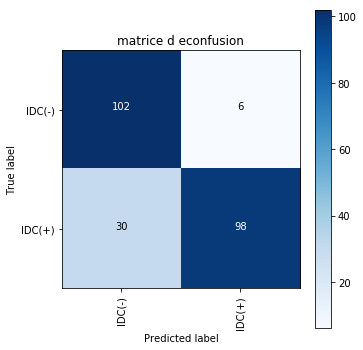

In [6]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
class MetricsCheckpoint(Callback):
    """apres chaque epoch en sauvegarde metrics"""
    def __init__(self, savepath):
        #constructeur de la class
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    #en affiche juste la courbe de notre model
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('nombre d epoques')
def runKerasCNN(a,b,c,d):
    """
    en a utiliser ce lien
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    en a utilise run model qui marche bien sur MNIST sur notre dataset
    """
    batch_size = 128
    num_classes = 2
    epochs = 5
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    #test d'un premier model
    #test d'un premier model
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    # load weights
    model.load_weights("weights.traint_40zoom_modelcomplex_avec_crop.hdf5")
    for layer in model.layers[:15]:
        layer.trainable = False
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    filepath="weights.traint_40_400_zoom_modelcomplex_avec_15layer.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    history =model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=100,
              validation_data=(x_test, y_test),callbacks=callbacks_list)
    model.summary()
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN 1 - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values()))
     
runKerasCNN(X_train, Y_train,  X_test, Y_test)
#plotKerasLearningCurve()